In [1]:
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.linear_model import LogisticRegression as Logit
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.naive_bayes import GaussianNB


# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

In [2]:
# Load Census Bureau Household Pulse Survey data
hps = pd.read_csv("hps_data.csv")
hps.head()

,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,PSWHYCHG1,PSWHYCHG2,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,INCOME
0,V340000001S34010804300113,34,1,NaN,2,1548.941305,2889.966484,1986,2,1,...,-88,-88,-88,-88,-88,-88,-88,-88,-88,7
1,V340000001S37010632600113,34,1,NaN,2,1080.178856,3023.046143,1967,2,2,...,-88,-88,-88,-88,-88,-88,-88,-88,-88,4
2,V340000001S52011057710113,34,1,NaN,2,1542.979030,4318.263387,1941,2,1,...,-88,-88,-88,-88,-88,-88,-88,-88,-88,4
3,V340000001S79010365210123,34,1,NaN,2,1111.825305,2074.409055,1962,2,1,...,-88,-88,-88,-88,-88,-88,-88,-88,-88,8
4,V340000002S01021059400123,34,2,NaN,4,87.544682,173.361259,1975,2,1,...,-88,-88,-88,-88,-88,-88,-88,-88,-88,5


In [3]:
# Load CDC data
cdc = pd.read_csv("COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv")
cdc.head()

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_12Plus,...,Additional_Doses_18Plus,Additional_Doses_18Plus_Vax_Pct,Additional_Doses_50Plus,Additional_Doses_50Plus_Vax_Pct,Additional_Doses_65Plus,Additional_Doses_65Plus_Vax_Pct,Additional_Doses_Moderna,Additional_Doses_Pfizer,Additional_Doses_Janssen,Additional_Doses_Unk_Manuf
0,11/16/2021,46,HI,2738800,111700,1025160,1601940,0,193436,226140,...,102827.0,12.8,80786.0,18.4,58275.0,24.6,24145.0,78252.0,570.0,2.0
1,11/16/2021,46,IL,20805235,1033300,7663400,12108535,0,164185,191969,...,1384001.0,19.2,1066406.0,28.7,745263.0,41.9,528502.0,844422.0,12021.0,457.0
2,11/16/2021,46,OH,17728785,833000,6991380,9904405,0,151669,177275,...,1191580.0,20.6,977371.0,29.1,722517.0,41.5,465407.0,710412.0,16840.0,222.0
3,11/16/2021,46,TX,47765235,2325500,17998260,27441475,0,164731,198187,...,2236905.0,15.5,1695704.0,24.9,1101393.0,35.8,951389.0,1264475.0,25356.0,68.0
4,11/16/2021,46,BP2,285240,15600,122220,147420,0,0,0,...,8686.0,7.0,3062.0,10.9,548.0,15.4,4184.0,4386.0,96.0,20.0


The Census Bureau website indicates that our data was generated during week 34 of phase 3.2. This means that this specific data was collected on July 21st, 2021. So, we're going to subset our CDC data to 7/21/2021 before we merge it with the HPS data.

In [4]:
# Subset CDC data
cdc_new = cdc[cdc["Date"] == '7/21/2021']
cdc_new.head()

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_12Plus,...,Additional_Doses_18Plus,Additional_Doses_18Plus_Vax_Pct,Additional_Doses_50Plus,Additional_Doses_50Plus_Vax_Pct,Additional_Doses_65Plus,Additional_Doses_65Plus_Vax_Pct,Additional_Doses_Moderna,Additional_Doses_Pfizer,Additional_Doses_Janssen,Additional_Doses_Unk_Manuf
7644,7/21/2021,29,CT,4828735,250000,1957680,2621055,0,135437,155467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7645,7/21/2021,29,NM,2413065,138500,1050040,1224525,0,115082,135002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7646,7/21/2021,29,IN,6852890,427500,2734160,3691230,0,101792,120120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7647,7/21/2021,29,ME,1887110,103100,811560,972450,0,140388,159258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7648,7/21/2021,29,TX,32549095,1894600,13134540,17519955,0,112254,135052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


When we merge the two datasets, we are going to merge on the variable **state**. Now, while both of the datasets contain state-level information, they do so under different variable names and formats. The Census Bureau variable is called **EST_ST** and is recorded in the dataframe using numbers that correspond to states that are recorded in the codebook. The CDC variable is called **Location** and records state abbreviations. Our next step is to assign copies of these variables named state in each dataframe, and then create a dictionary containing the information from the HPS codebook and replace the numeric values in the HPS dataframe with state abbreviations to match the information in the CDC dataframe.

In [5]:
# Unique values of states from the HPS dataframe
hps.EST_ST.unique()

array([ 1,  2,  6,  4,  5,  8, 37,  9, 10, 12, 13, 15, 24, 16, 26, 46, 29,
       17, 18, 53, 19, 48, 42, 25, 34, 45, 36, 33, 55, 20, 40, 21, 31, 41,
       22, 23, 47, 27, 51, 28, 30, 49, 32, 39, 35, 38, 44, 56, 11, 50, 54],
      dtype=int64)

In [6]:
# Unique values of states from the CDC dataframe
cdc_new.Location.unique()

array(['CT', 'NM', 'IN', 'ME', 'TX', 'NC', 'GU', 'AR', 'NJ', 'TN', 'PA',
       'AS', 'HI', 'RI', 'KY', 'RP', 'NY', 'WY', 'MD', 'OR', 'OH', 'DE',
       'NV', 'LA', 'MT', 'VI', 'NH', 'WV', 'NE', 'MN', 'LTC', 'CO', 'OK',
       'VT', 'WA', 'ID', 'CA', 'IH2', 'VA', 'SC', 'FL', 'MA', 'VA2',
       'BP2', 'US', 'MS', 'MP', 'DD2', 'AK', 'DC', 'SD', 'MO', 'WI', 'GA',
       'FM', 'AL', 'KS', 'MH', 'IA', 'IL', 'MI', 'UT', 'ND', 'AZ', 'PR'],
      dtype=object)

In [7]:
hps = hps.assign(state = hps.EST_ST)

In [8]:
cdc_new = cdc_new.assign(state = cdc_new.Location)

In [9]:
# Replace values in hps using a dictionary created from value of states in hps codebook
states_key = {1:'AL', 2:'AK', 4:'AZ', 5:'AR', 6:'CA', 8:'CO', 9:'CT', 10:'DE', 11:'DC', 12:'FL', 13:'GA', 15:'HI',16:'ID', 
              17:'IL', 18:'IN', 19:'IA', 20:'KS', 21:'KY', 22:'LA', 23:'ME', 24:'MD', 25:'MA', 26:'MI', 27:'MN', 28:'MS',
              29:'MO', 30:'MT', 31:'NE', 32:'NV', 33:'NH', 34:'NJ', 35:'NM', 36:'NY', 37:'NC', 38:'ND', 39:'OH', 40:'OK',
              41:'OR', 42:'PA', 44:'RI', 45:'SC', 46:'SD', 47:'TN', 48:'TX', 49:'UT', 50:'VT', 51:'VA', 53:'WA', 54:'WV',
              55:'WI', 56:'WY'}

hps.state.replace(states_key, inplace=True)

In [10]:
hps.state

0        AL
1        AL
2        AL
3        AL
4        AK
         ..
64557    WI
64558    WY
64559    WY
64560    FL
64561    ID
Name: state, Length: 64562, dtype: object

In [11]:
# Choose variables needed from cdc_new
cdc_vars = cdc_new[['state','Distributed','Dist_Per_100K', 'Administered', 'Admin_Per_100K', 'Series_Complete_Pop_Pct', 
                    'Administered_Dose1_Pop_Pct']]

# Merge dataframes together
combined_df = hps.merge(cdc_vars, how="left", on="state")

combined_df.head()

,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,PSWHYCHG8,PSWHYCHG9,INCOME,state,Distributed,Dist_Per_100K,Administered,Admin_Per_100K,Series_Complete_Pop_Pct,Administered_Dose1_Pop_Pct
0,V340000001S34010804300113,34,1,NaN,2,1548.941305,2889.966484,1986,2,1,...,-88,-88,7,AL,4935470,100658,3485659,71090,33.9,41.5
1,V340000001S37010632600113,34,1,NaN,2,1080.178856,3023.046143,1967,2,2,...,-88,-88,4,AL,4935470,100658,3485659,71090,33.9,41.5
2,V340000001S52011057710113,34,1,NaN,2,1542.979030,4318.263387,1941,2,1,...,-88,-88,4,AL,4935470,100658,3485659,71090,33.9,41.5
3,V340000001S79010365210123,34,1,NaN,2,1111.825305,2074.409055,1962,2,1,...,-88,-88,8,AL,4935470,100658,3485659,71090,33.9,41.5
4,V340000002S01021059400123,34,2,NaN,4,87.544682,173.361259,1975,2,1,...,-88,-88,5,AK,846475,115711,688769,94153,45.1,50.7


In [12]:
# Replace missing data (-88 and -99 according to codebook) as NaN type
combined_df = combined_df.replace(-88, np.NaN) # Missing response to question
combined_df = combined_df.replace(-99, np.NaN) # Question seen but not answered

In [13]:
# Look at missing data
#miss.matrix(combined_df)

In [14]:
combined_df.RECVDVACC = combined_df.RECVDVACC.replace(2, 0) # Replacing "No" responses with 0 so this variable becomes a dummy

In [15]:
combined_df.RECVDVACC.describe()

count    63772.000000
mean         0.879226
std          0.325867
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: RECVDVACC, dtype: float64

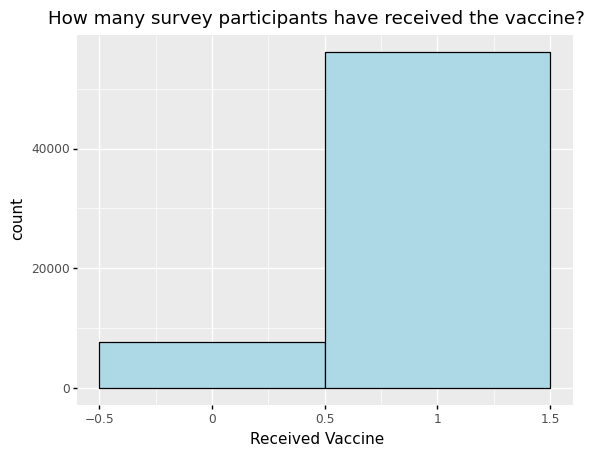

<ggplot: (123703973602)>

In [16]:
# Age Distribution
(ggplot(combined_df, aes('RECVDVACC')) +
  geom_histogram(color = "black", fill = "lightblue", bins=2) +
  labs(x="Received Vaccine", title = "How many survey participants have received the vaccine?"))

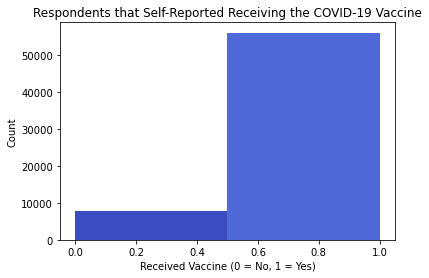

In [17]:
n, bins, patches = plt.hist(combined_df.RECVDVACC, bins=2)
cm = plt.cm.get_cmap('coolwarm')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/15)) # notice the i/25

plt.xlabel("Received Vaccine (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.title("Respondents that Self-Reported Receiving the COVID-19 Vaccine")
plt.show()

In [18]:
combined_df.GETVACRV.describe()

count    7710.000000
mean        3.804929
std         1.274016
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: GETVACRV, dtype: float64

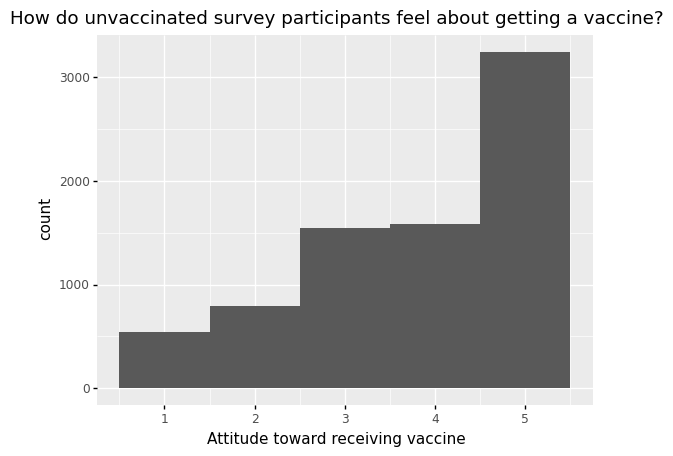

<ggplot: (123615021014)>

In [19]:
(ggplot(combined_df, aes(x='GETVACRV', fill='GETVACRV')) +
  geom_histogram(bins=5) +
  scale_fill_gradient(low='blue', high='red') +
  labs(x="Attitude toward receiving vaccine", title = "How do unvaccinated survey participants feel about getting a vaccine?"))

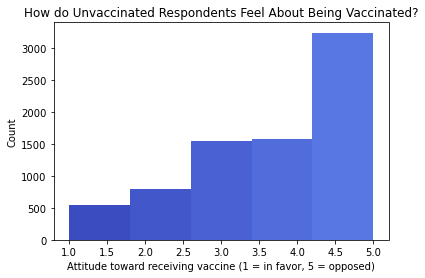

In [20]:
n, bins, patches = plt.hist(combined_df.GETVACRV, bins=5)
cm = plt.cm.get_cmap('coolwarm')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/40)) # notice the i/25

plt.xlabel("Attitude toward receiving vaccine (1 = in favor, 5 = opposed)")
plt.ylabel("Count")
plt.title("How do Unvaccinated Respondents Feel About Being Vaccinated?")
plt.show()

For the above graph, 1 indicates definitely receiving vaccine, 2 indicates probably receiving vaccine, 3 indicates unsure about receiving vaccine, 4 indicates probably won't receive vaccine, 5 indicates definitely won't receive vaccine.

In [21]:
cdc_new.Series_Complete_Pop_Pct.describe()

count    65.000000
mean     44.718462
std      14.971482
min       0.000000
25%      38.900000
50%      46.000000
75%      53.700000
max      75.200000
Name: Series_Complete_Pop_Pct, dtype: float64

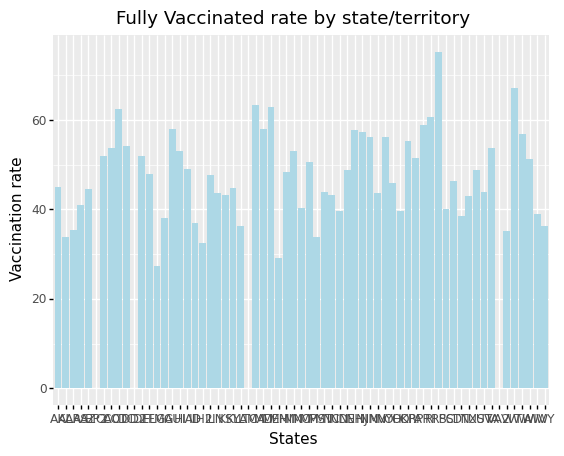

<ggplot: (123615020084)>

In [22]:
(ggplot(cdc_new, aes(x='state',y='Series_Complete_Pop_Pct')) +
  geom_bar(stat='identity', fill = "lightblue") +
  labs(x='States', y='Vaccination rate', title = "Fully Vaccinated rate by state/territory"))

In [23]:
# Filling values of interest that are missing
 #for i in list(combined_df.index):
        #if combined_df.loc[i,]

In [24]:
# Concern about vaccine side effects
combined_df.WHYNORV1.describe()

count    4044.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: WHYNORV1, dtype: float64

In [25]:
combined_df.WHYNORV1=combined_df.WHYNORV1.fillna(0) # side effects concern
combined_df.WHYNORV2=combined_df.WHYNORV2.fillna(0) # unsure of vaccine protection
combined_df.WHYNORV3=combined_df.WHYNORV3.fillna(0) # doesn't believe vaccine is necessary
combined_df.WHYNORV6=combined_df.WHYNORV6.fillna(0) # cost concern
combined_df.WHYNORV7=combined_df.WHYNORV7.fillna(0) # distrust of the vaccine
combined_df.WHYNORV8=combined_df.WHYNORV8.fillna(0) # distrust of the government
combined_df.WHYNORV9=combined_df.WHYNORV9.fillna(0) # doesn't see COVID-19 as a threat
combined_df.WHYNORV11=combined_df.WHYNORV11.fillna(0) # believes that one dose is enough protection

In [26]:
combined_df = combined_df[['Series_Complete_Pop_Pct','Administered_Dose1_Pop_Pct','RECVDVACC','GETVACRV','WHYNORV1','WHYNORV2','WHYNORV3','WHYNORV6','WHYNORV7','WHYNORV8','WHYNORV9','WHYNORV11','state']]
rs = np.random.RandomState(0)
corr = combined_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Series_Complete_Pop_Pct,Administered_Dose1_Pop_Pct,RECVDVACC,GETVACRV,WHYNORV1,WHYNORV2,WHYNORV3,WHYNORV6,WHYNORV7,WHYNORV8,WHYNORV9,WHYNORV11
Series_Complete_Pop_Pct,1.000000,0.948558,0.120929,-0.013485,-0.085339,-0.058850,-0.056763,-0.019153,-0.069400,-0.061017,-0.043485,0.004612
Administered_Dose1_Pop_Pct,0.948558,1.000000,0.125459,-0.029115,-0.090380,-0.059586,-0.060933,-0.020803,-0.075670,-0.065251,-0.047542,0.004903
RECVDVACC,0.120929,0.125459,1.000000,nan,-0.689274,-0.419458,-0.458443,-0.131383,-0.585403,-0.513511,-0.389400,0.006727
GETVACRV,-0.013485,-0.029115,nan,1.000000,0.146483,0.091243,0.318980,-0.005315,0.380670,0.320808,0.275616,nan
WHYNORV1,-0.085339,-0.090380,-0.689274,0.146483,1.000000,0.504006,0.443247,0.142914,0.609411,0.520400,0.418081,0.034331
WHYNORV2,-0.058850,-0.059586,-0.419458,0.091243,0.504006,1.000000,0.351801,0.167576,0.454165,0.398440,0.325541,0.019545
WHYNORV3,-0.056763,-0.060933,-0.458443,0.318980,0.443247,0.351801,1.000000,0.104650,0.503519,0.477476,0.617300,0.027811
WHYNORV6,-0.019153,-0.020803,-0.131383,-0.005315,0.142914,0.167576,0.104650,1.000000,0.113084,0.114596,0.098530,0.016264
WHYNORV7,-0.069400,-0.075670,-0.585403,0.380670,0.609411,0.454165,0.503519,0.113084,1.000000,0.623026,0.473357,0.024730
WHYNORV8,-0.061017,-0.065251,-0.513511,0.320808,0.520400,0.398440,0.477476,0.114596,0.623026,1.000000,0.480911,0.028695


In [27]:
# Subsetting data frame to only include people who have not been vaccinated
combined_df_subset = combined_df[combined_df.RECVDVACC == 0]
combined_df_subset

,Series_Complete_Pop_Pct,Administered_Dose1_Pop_Pct,RECVDVACC,GETVACRV,WHYNORV1,WHYNORV2,WHYNORV3,WHYNORV6,WHYNORV7,WHYNORV8,WHYNORV9,WHYNORV11,state
1,33.9,41.5,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,AL
3,33.9,41.5,0.0,5.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,AL
9,51.9,63.5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CA
15,45.1,50.7,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK
16,45.1,50.7,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64535,56.8,63.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,WA
64537,56.8,63.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,WA
64540,38.9,45.8,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WV
64547,38.9,45.8,0.0,5.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,WV


In [28]:
combined_df_subset = combined_df_subset.drop(columns=['RECVDVACC', 'WHYNORV11'])
combined_df_subset

,Series_Complete_Pop_Pct,Administered_Dose1_Pop_Pct,GETVACRV,WHYNORV1,WHYNORV2,WHYNORV3,WHYNORV6,WHYNORV7,WHYNORV8,WHYNORV9,state
1,33.9,41.5,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AL
3,33.9,41.5,5.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,AL
9,51.9,63.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CA
15,45.1,50.7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK
16,45.1,50.7,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,AK
...,...,...,...,...,...,...,...,...,...,...,...
64535,56.8,63.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,WA
64537,56.8,63.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,WA
64540,38.9,45.8,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WV
64547,38.9,45.8,5.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,WV


In [29]:
corr = combined_df_subset.corr()
corr.style.background_gradient(cmap='coolwarm')

,Series_Complete_Pop_Pct,Administered_Dose1_Pop_Pct,GETVACRV,WHYNORV1,WHYNORV2,WHYNORV3,WHYNORV6,WHYNORV7,WHYNORV8,WHYNORV9
Series_Complete_Pop_Pct,1.000000,0.953636,-0.011150,-0.008048,-0.025315,-0.005713,-0.008228,0.004652,0.004471,0.011514
Administered_Dose1_Pop_Pct,0.953636,1.000000,-0.025167,-0.013668,-0.021812,-0.012441,-0.011570,-0.007608,-0.001380,0.004518
GETVACRV,-0.011150,-0.025167,1.000000,0.134460,0.086478,0.316517,-0.007307,0.377473,0.317989,0.274144
WHYNORV1,-0.008048,-0.013668,0.134460,1.000000,0.325031,0.194758,0.068382,0.344928,0.261442,0.219773
WHYNORV2,-0.025315,-0.021812,0.086478,0.325031,1.000000,0.195323,0.119391,0.280006,0.230716,0.189299
WHYNORV3,-0.005713,-0.012441,0.316517,0.194758,0.195323,1.000000,0.047846,0.324880,0.314788,0.532406
WHYNORV6,-0.008228,-0.011570,-0.007307,0.068382,0.119391,0.047846,1.000000,0.042941,0.051609,0.046360
WHYNORV7,0.004652,-0.007608,0.377473,0.344928,0.280006,0.324880,0.042941,1.000000,0.460844,0.326543
WHYNORV8,0.004471,-0.001380,0.317989,0.261442,0.230716,0.314788,0.051609,0.460844,1.000000,0.350264
WHYNORV9,0.011514,0.004518,0.274144,0.219773,0.189299,0.532406,0.046360,0.326543,0.350264,1.000000


<AxesSubplot:>

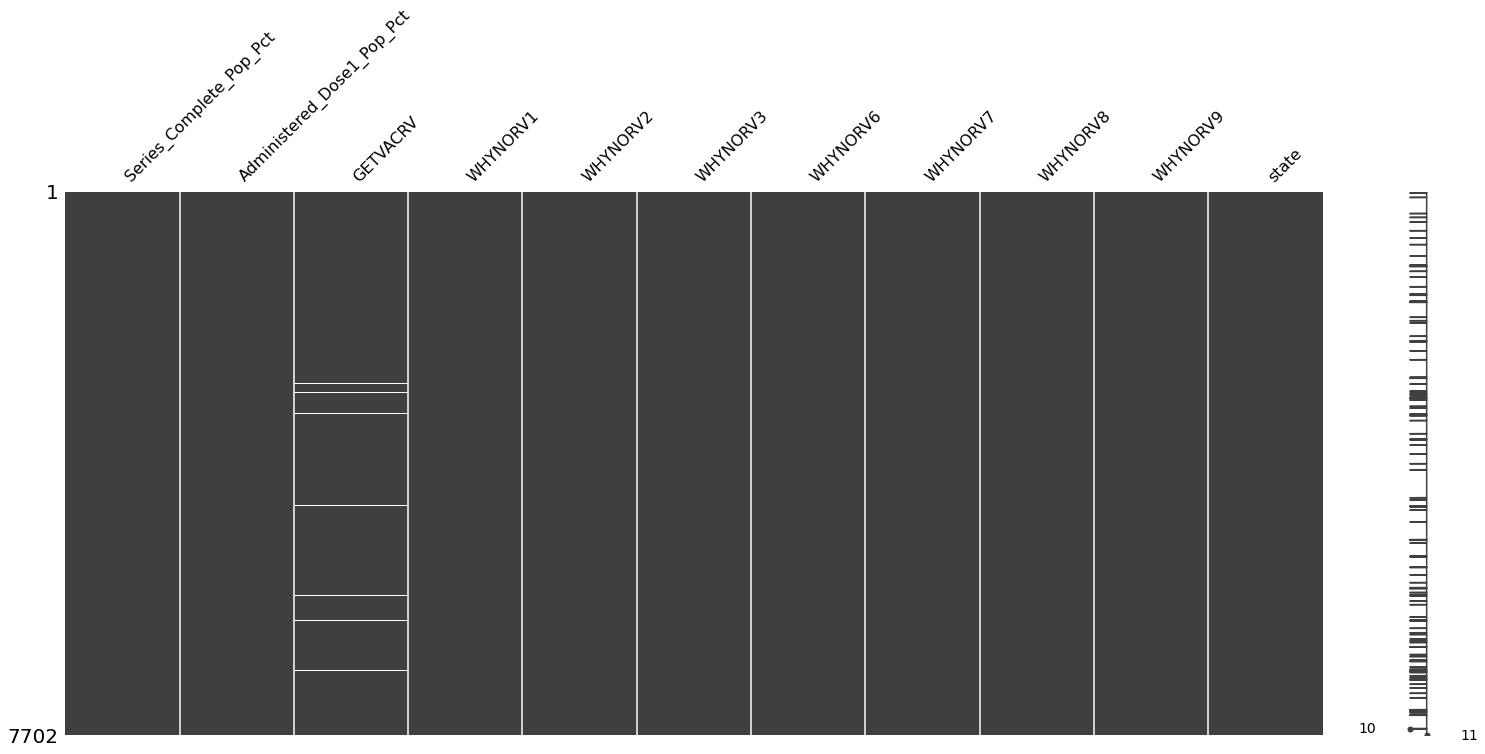

In [30]:
miss.matrix(combined_df_subset)

In [31]:
combined_df_subset = combined_df_subset[~combined_df_subset.GETVACRV.isna()]
combined_df_subset.shape

(7591, 11)

In [32]:
combined_df_subset['GETVACRV_bins'] = pd.cut(combined_df_subset.GETVACRV, bins = 2, labels = ['1-3', '4-5'])
combined_df_subset

,Series_Complete_Pop_Pct,Administered_Dose1_Pop_Pct,GETVACRV,WHYNORV1,WHYNORV2,WHYNORV3,WHYNORV6,WHYNORV7,WHYNORV8,WHYNORV9,state,GETVACRV_bins
1,33.9,41.5,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AL,1-3
3,33.9,41.5,5.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,AL,4-5
9,51.9,63.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CA,4-5
15,45.1,50.7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK,1-3
16,45.1,50.7,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,AK,4-5
...,...,...,...,...,...,...,...,...,...,...,...,...
64535,56.8,63.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,WA,1-3
64537,56.8,63.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,WA,4-5
64540,38.9,45.8,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WV,1-3
64547,38.9,45.8,5.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,WV,4-5


In [33]:
combined_df_subset = pd.get_dummies(combined_df_subset)
combined_df_subset.columns

Index(['Series_Complete_Pop_Pct', 'Administered_Dose1_Pop_Pct', 'GETVACRV',
       'WHYNORV1', 'WHYNORV2', 'WHYNORV3', 'WHYNORV6', 'WHYNORV7', 'WHYNORV8',
       'WHYNORV9', 'state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA',
       'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS',
       'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI',
       'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND',
       'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
       'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
       'state_WA', 'state_WI', 'state_WV', 'state_WY', 'GETVACRV_bins_1-3',
       'GETVACRV_bins_4-5'],
      dtype='object')

In [34]:
y = combined_df_subset['GETVACRV_bins_4-5']
X = combined_df_subset[['Series_Complete_Pop_Pct', 'Administered_Dose1_Pop_Pct',
       'WHYNORV1', 'WHYNORV2', 'WHYNORV3', 'WHYNORV6', 'WHYNORV7', 'WHYNORV8',
       'WHYNORV9']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.2,random_state=42)

In [35]:
train_X.shape

(6072, 9)

In [36]:
train_y.shape

(6072,)

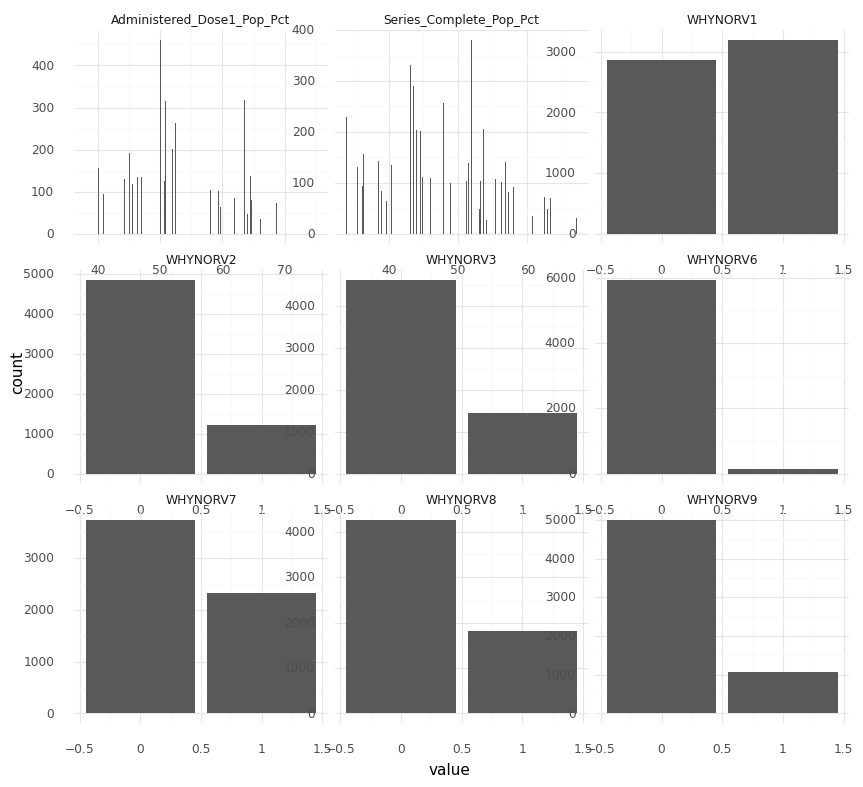

<ggplot: (123615892718)>

In [37]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,9)) 
) 

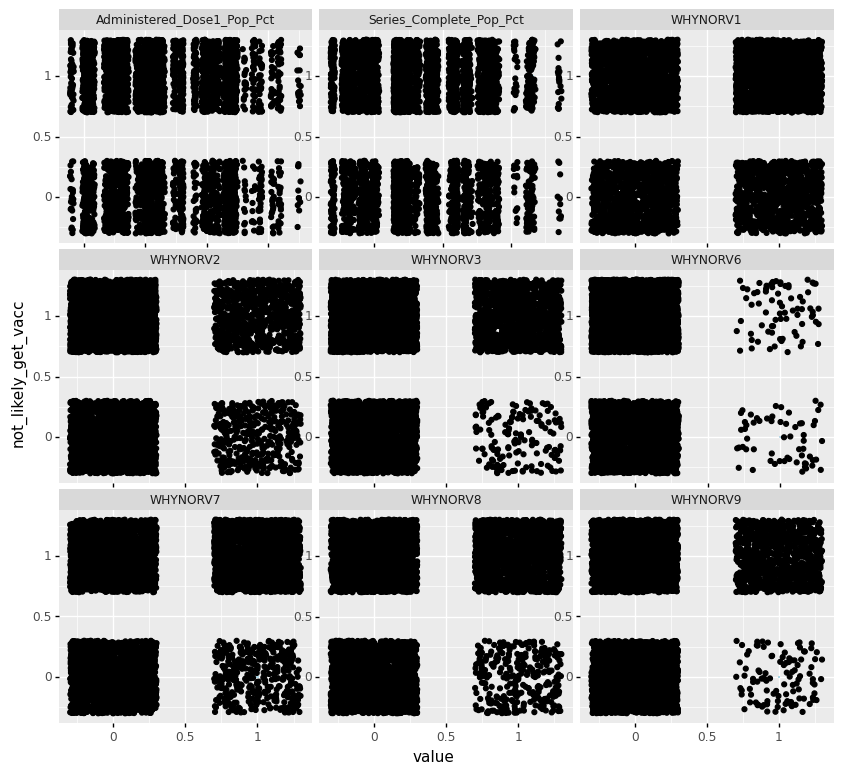

<ggplot: (123620100271)>

In [65]:
D = train_X.copy()
D['not_likely_get_vacc'] = train_y

(
    ggplot(D.melt(id_vars=['not_likely_get_vacc']),
           aes(x="value",y="not_likely_get_vacc"))+
    geom_point(alpha=.005, color='lightblue', size=0.005) +
    geom_jitter(height=0.3,width=0.3) +
    facet_wrap("variable",scales="free") +
    theme(figure_size = (10,9)) 
)

In [39]:
fold_generator = KFold(n_splits=5, shuffle=True,random_state=42)

# Specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['Series_Complete_Pop_Pct', 'Administered_Dose1_Pop_Pct',
       'WHYNORV1', 'WHYNORV2', 'WHYNORV3', 'WHYNORV6', 'WHYNORV7', 'WHYNORV8',
       'WHYNORV9'])])


# Create our model pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# Specify the models and their repsective tuning parameters. 
search_space = [
    # Linear Regression
    {'model' : [LM()]},
    
    # Logistic Regression
    {'model' : [Logit()]},
    
    # Naive Bayes Classifier
    {'model' : [GaussianNB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4,5]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250,1500]},
]

In [40]:
# Put together pipeline in grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# Fit modeling pipeline to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Series_Complete_Pop_Pct',
                                                                          'Administered_Dose1_Pop_Pct',
                                                                          'WHYNORV1',
                                                                          'WHYNORV2',
                                                                          'WHYNORV3',
                                                                          'WHYNORV6',
                                                                          'WHYNORV7',
                                                                          '

In [41]:
search.best_params_

{'model': DecisionTreeRegressor(max_depth=4), 'model__max_depth': 4}

In [42]:
search.best_score_

-0.1893958009281127

In [43]:
search_roc = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

search_roc.fit(train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Series_Complete_Pop_Pct',
                                                                          'Administered_Dose1_Pop_Pct',
                                                                          'WHYNORV1',
                                                                          'WHYNORV2',
                                                                          'WHYNORV3',
                                                                          'WHYNORV6',
                                                                          'WHYNORV7',
                                                                          '

In [44]:
search_roc.best_params_

{'model': LogisticRegression()}

In [45]:
search_roc.best_score_

0.7546786237563549

In [46]:
LM().get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [47]:
Logit().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [48]:
pred_y = search_roc.predict(test_X)
m.roc_auc_score(test_y,pred_y)

0.7191461801344945

In [49]:
m.mean_squared_error(test_y,pred_y)

0.28110599078341014

In [50]:
rf_mod = search_roc.best_estimator_
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

In [51]:
# Organize permutations as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# Show data frame
vi_dat

,variable,vi,std,low,high
0,WHYNORV7,0.070559,0.004736,0.061086,0.080032
1,WHYNORV3,0.042468,0.003639,0.035190,0.049747
2,WHYNORV8,0.035321,0.004531,0.026259,0.044383
3,WHYNORV9,0.017496,0.003236,0.011024,0.023967
4,Administered_Dose1_Pop_Pct,0.013126,0.003448,0.006229,0.020022
5,Series_Complete_Pop_Pct,0.012484,0.002320,0.007845,0.017123
6,WHYNORV6,0.000522,0.000604,-0.000687,0.001730
7,WHYNORV1,0.000011,0.000719,-0.001427,0.001449
8,WHYNORV2,-0.000121,0.001004,-0.002130,0.001888


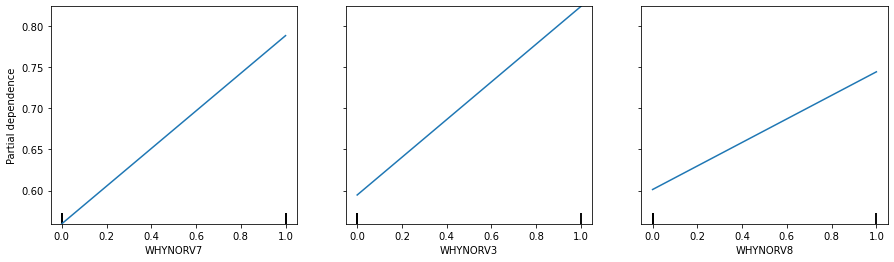

In [52]:
# Target specific features
features = ['WHYNORV7','WHYNORV3','WHYNORV8']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)